## Investigation into causes and effects of the negative Sea Ice anomaly in Kotzebue Sound, Alaska during the 2017/18 Winter Season

### Motivations

I am involved in a multi-year study of the Marginal Ice Zone and ice breakup processes in Kotzebue Sound, Arctic Alaska. This project is named 'Ikaagvik Sikukuun', which translates approximately to 'Ice Bridges' and is abbreviated to 'IkSi'.

The winter of 2017-2018 saw an extremely anomalous year for ice formation in the Sound, with the Native community of Kotzebue reporting that it was "the worst freeze-up in living memory", as the Sound itself never froze over completely, and the breakup process began especially early. The figure below illustrates this with visible imagery from MODIS on April 19 of each year:

![alt text](Ice_mod_apr19.png)

I will be using the past 15 years of Satellite and ground-based observations to investigate trends, causes, and effects of this anomaly.

First I'll import all the packages needed for this analysis, and define spatio-temporal limits that will be applied across all datasets.

In [16]:
import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import cartopy

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)

The spatial limits encapsulate the Kotzebue Sound and the regional Marginal Ice Zone in the Chukchi Sea, which is the study area for the IkSi project:

In [17]:
#intialize spatial limits for all datasets
lat_min, lat_max = 65.479474, 68.708048
lon_min, lon_max = -169.259880, -160.007140

The temporal limits go back to the beginning of 2003. This timeframe was chosen for several reasons:

- To understand the 2017/18 winter as an anomaly even within recent times, but extend far enough back to establish a meaningful climatology.

- All datasets being used are very reliable when extended back only 16 years - the quality of the data starts to come into question as we look further back in time.

- This is also the length of the observational journal that has been kept by Alex Whiting, our local collaborator in Kotzebue. I would eventually like to examine his journal as a companion to this analysis.

In [18]:
#initialize temporal limits for all datasets
start_date = pd.datetime(2003,1,1)
end_date = pd.datetime(2018,11,1)
end_date_plot = pd.datetime(2019,1,1)

ddts = pd.date_range(start=start_date,end=end_date) #"daily-date-times"
ydts = pd.date_range(start=start_date,end=end_date_plot,freq='A-JAN') #"yearly-date-times"

### Data Products

The [Reynolds SST and Sea Ice Cover](https://journals.ametsoc.org/doi/full/10.1175/2007JCLI1824.1) data product is a composite of satellite and in situ measurements, interpolated spatiotemporally across the globe. 

The advantage of a product like this is that it incorporates multiple types of observations and is thus less susceptible to instrumentation bias. However it is interpolated across (potentially large) gaps in space and time, which makes analysis simpler but removes it from the category of a direct measurement. So I also use satellite products for both SST and Sea Ice Cover to corroborate the Reynolds composite. These are 'high-level' satellite products, meaning they have already been processed and quality-controlled.


The [MODIS SST](https://modis.gsfc.nasa.gov/data/dataprod/mod28.php) product is derived from MODIS Aqua and Terra Satellites using infrared-band remote sensing techniques. It cannot see through clouds so is spatially and temporally incomplete, necessitating a NaN-agnostic aggregation method in order to draw meaningful conclusions from the data.


The [SSMI Sea Ice Cover](http://icdc.cen.uni-hamburg.de/1/daten/cryosphere/seaiceconcentration-asi-ssmi.html) product is derived from the SSM/I Satellite using passive microwave sensing. It is transparent to clouds and thus has minimal data gaps - however it should be noted that this is also because the ICDC in Hamburg, who produce the product, interpolate for any missing data in their processing.


Finally, the [OTZ Airport Meteorological Record](https://wrcc.dri.edu/cgi-bin/cliMAIN.pl?akkotz) appears to be partially available online but was acquired in person in Kotzebue. This contains all the traditional weather station variables (save for radiation) - most of which are logged on an hourly timescale.



### Data Access
[Reynolds SST and Sea Ice Cover](https://www.ncei.noaa.gov/thredds/catalog/OisstBase/NetCDF/AVHRR/catalog.html) via OpenDAP

[MODIS SST](https://opendap.jpl.nasa.gov/opendap/OceanTemperature/modis/L3/aqua/11um/v2014.0/4km/daily/contents.html) via OpenDAP

[SSMI Sea Ice Cover](http://icdc.cen.uni-hamburg.de/thredds/dodsC/) via OpenDAP


----------------------------------------------------
### Importing

This analysis relies on multiple satellite and composite data products, which I imported lazily (from various OpenDAP servers hosted by NASA, NOAA, and the ICDC), subsetted into the timeframe and region of interest defined above, and re-saved as significantly smaller NetCDF files. These importing steps can be found in Witte-Rces-Importing.ipynb. All told, these importing steps take about 10 hours to run lazily. 

So, in this notebook we will import pre-formatted datasets:

In [44]:
#reynolds composite sst and ice cover product:
sst_rey = xr.open_dataset('sst_reynolds.nc')

#modis daytime sst product: files are split up by year so that they will be small enough for github
#sst_mod_day = xr.open_dataset('sst_modis_day.nc')
modis_files = []
for year in np.arange(2003,2019):
    modis_files.append(f'sst_modis_day_{year}.nc')
sst_mod_day = xr.open_mfdataset(modis_files)
#sst_mod_day = sst_mod_day.sst.chunk(chunks=(5784,77,222)) #I have to open_mfdataset and then un-chunk the dataset as a workaround to make this function smoothly in binder
#sst_mod_day = sst_mod_day.compute()

#hamburg icdc ssmi sea ice product:
ssmi = xr.open_dataarray('seaice_all.nc')

#local weather station data: (messy csv set, requires a bit of cleaning)
df = pd.read_csv('otz-met-data.csv',parse_dates=['DATE'],low_memory=False,dtype={'STATION':str,'STATION_NAME':str})
df = df.set_index('DATE')
df.ELEVATION = pd.to_numeric(df.ELEVATION, errors='coerce')
df.LATITUDE = pd.to_numeric(df.LATITUDE, errors='coerce')
df.LONGITUDE = pd.to_numeric(df.LONGITUDE, errors='coerce')
df.HOURLYDRYBULBTEMPF = pd.to_numeric(df.HOURLYDRYBULBTEMPF, errors='coerce')
df.HOURLYDRYBULBTEMPC = pd.to_numeric(df.HOURLYDRYBULBTEMPC, errors='coerce')
df.HOURLYWETBULBTEMPF = pd.to_numeric(df.HOURLYWETBULBTEMPF, errors='coerce')
df.HOURLYWETBULBTEMPC = pd.to_numeric(df.HOURLYWETBULBTEMPC, errors='coerce')
df.HOURLYDewPointTempF = pd.to_numeric(df.HOURLYDewPointTempF, errors='coerce')
df.HOURLYDewPointTempC = pd.to_numeric(df.HOURLYDewPointTempC, errors='coerce')
df.HOURLYRelativeHumidity = pd.to_numeric(df.HOURLYRelativeHumidity, errors='coerce')
df.HOURLYWindSpeed = pd.to_numeric(df.HOURLYWindSpeed, errors='coerce')
df.HOURLYWindDirection = pd.to_numeric(df.HOURLYWindDirection, errors='coerce')
df.HOURLYStationPressure = pd.to_numeric(df.HOURLYStationPressure, errors='coerce')
df.HOURLYSeaLevelPressure = pd.to_numeric(df.HOURLYSeaLevelPressure, errors='coerce')
df.HOURLYPrecip = pd.to_numeric(df.HOURLYPrecip, errors='coerce')
df.HOURLYAltimeterSetting = pd.to_numeric(df.HOURLYAltimeterSetting, errors='coerce')
df.DAILYPrecip = pd.to_numeric(df.DAILYPrecip, errors='coerce')
df.DAILYSnowfall = pd.to_numeric(df.DAILYSnowfall, errors='coerce')
df.DAILYSnowDepth = pd.to_numeric(df.DAILYSnowDepth, errors='coerce')
met = df.to_xarray().sel(DATE = slice('2003-01-01','2018-10-31'))

ssmi_ex = xr.open_dataset('ssmi_ex.nc')
ssmi_ex = ssmi_ex / 100

Calculate Anomalies from a 15-year Monthly Climatology:

In [45]:
sst_rey_anom = sst_rey.groupby('time.month') - sst_rey.groupby('time.month').mean(dim='time')

sst_modday_anom = sst_mod_day.groupby('time.month') - sst_mod_day.groupby('time.month').mean(dim='time')
sst_modday_anom = sst_modday_anom.sst.chunk(chunks=(365,77,222))

met_anom = met.groupby('DATE.month') - met.groupby('DATE.month').mean(dim='DATE')
met_anom_1D = met_anom.resample(DATE='D').mean()

ssmi_anom = ssmi.groupby('time.month') - ssmi.groupby('time.month').mean(dim='time')
ssmi_anom = ssmi_anom / 100

--------------------------------------------------------------------------------
### Digging In

We'll first look at a plot of each of the 4 geospatial datasets to provide an understanding of the spatial extent and resolution of each dataset:

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


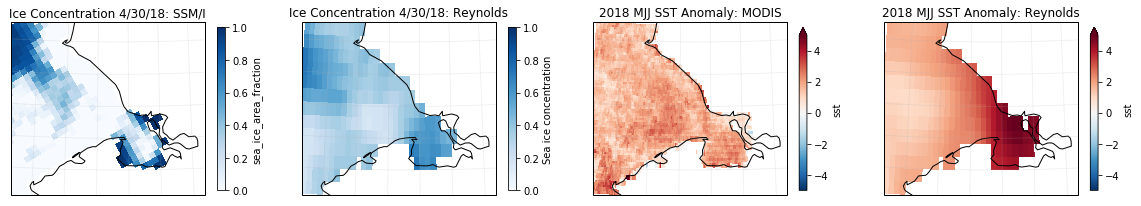

In [46]:
cmin_sst = -5
cmax_sst = 5
cmin_ice = 0
cmax_ice = 1
fig, axx = plt.subplots(nrows=1,ncols=4,figsize=(20,6),
                        subplot_kw={'projection': ccrs.LambertConformal(central_longitude=-164,
                                                                        central_latitude=67)})

axx[0].set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx[0].gridlines(alpha=0.2)
ssmi_ex.sea_ice_area_fraction.plot(x='longitude',y='latitude',cmap='Blues',vmin=cmin_ice,vmax=cmax_ice,
                                                       transform=ccrs.PlateCarree(),ax=axx[0],cbar_kwargs={'shrink': 0.5})
axx[0].set_title('Ice Concentration 4/30/18: SSM/I')
axx[0].coastlines(resolution='50m')


axx[1].set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx[1].gridlines(alpha=0.2)
sst_rey.sel(time='2018-04-30').ice.plot(transform=ccrs.PlateCarree(),
                                             ax=axx[1],cmap='Blues',vmin=cmin_ice,vmax=cmax_ice,cbar_kwargs={'shrink': 0.5})
axx[1].set_title('Ice Concentration 4/30/18: Reynolds')
axx[1].coastlines(resolution='50m')


axx[2].set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx[2].gridlines(alpha=0.2)
sst_modday_anom.resample(time='3m',skipna=True).mean('time').sel(time='2018-07-31').plot(transform=ccrs.PlateCarree(),
                                                     ax=axx[2],cmap='RdBu_r',vmin=cmin_sst,vmax=cmax_sst,cbar_kwargs={'shrink': 0.5})
axx[2].set_title('2018 MJJ SST Anomaly: MODIS')
axx[2].coastlines(resolution='50m')


axx[3].set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx[3].gridlines(alpha=0.2)
sst_rey_anom.resample(time='3m',skipna=True).mean('time').sel(time='2018-07-31').sst.plot(transform=ccrs.PlateCarree(),
                                                     ax=axx[3],cmap='RdBu_r',vmin=cmin_sst,vmax=cmax_sst,cbar_kwargs={'shrink': 0.5})
axx[3].set_title('2018 MJJ SST Anomaly: Reynolds')
axx[3].coastlines(resolution='50m');


Next we'll plot a timeseries of 15yr Monthly Anomalies to examine the temporal structure of our data and look for trends   
(all plots are centered rolling 30-day means except where otherwise specified by the legends):

/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


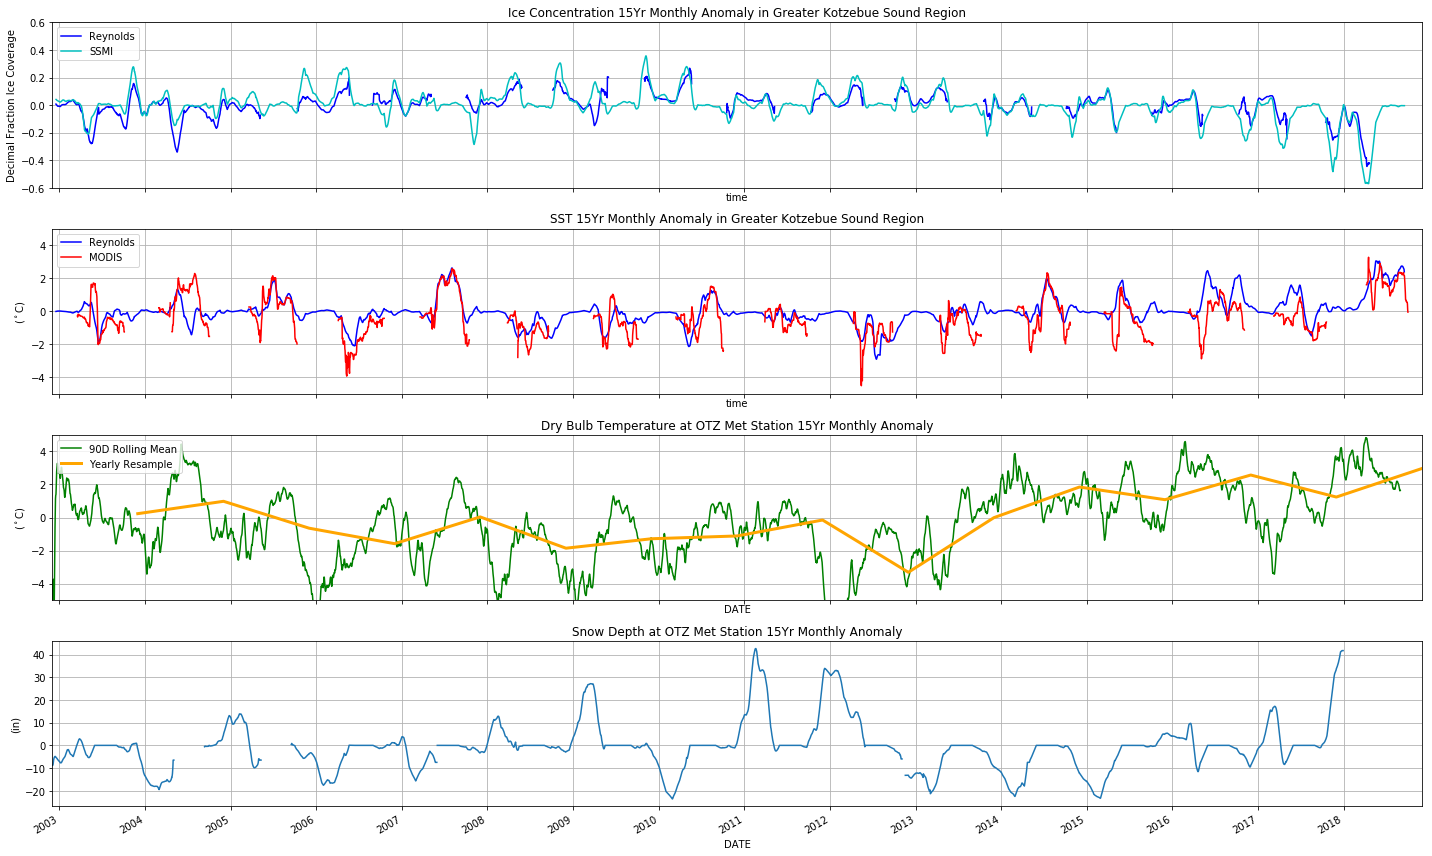

In [47]:
fig, axx = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(20,12))

sst_rey_anom.rolling(time=30, center=True).mean().ice.mean(dim={'lat','lon'}).plot(ax=axx[0],color='b')
ssmi_anom.rolling(time=30,center=True).mean().plot(ax=axx[0],color='c')
#ssmi_anom.resample(time='Y').mean('time').plot(ax=axx[0],color='gray')
axx[0].set_ylim(-0.6,0.6)
axx[0].set_ylabel('Decimal Fraction Ice Coverage')
axx[0].set_xlim(start_date, end_date_plot)
axx[0].grid()
axx[0].legend(('Reynolds','SSMI','SSMI 1Y Resample'),loc=2)
axx[0].set_xticks(ydts);
axx[0].set_title('Ice Concentration 15Yr Monthly Anomaly in Greater Kotzebue Sound Region')

sst_rey_anom.rolling(time=30, center=True).mean().sst.mean(dim={'lat','lon'}).plot(ax=axx[1],color='b')
sst_modday_anom.rolling(time=30, center=True, min_periods=5).mean().mean(dim={'lat','lon'}).plot(ax=axx[1],color='r')
#sst_modday_anom.resample(time='Y').mean('time').sst.mean(dim={'lat','lon'}).plot(ax=axx[1],color='gray')
axx[1].set_ylim(-5,5)
axx[1].set_ylabel('($^\circ$C)')
axx[1].set_xlim(start_date, end_date_plot)
axx[1].grid()
axx[1].legend(('Reynolds','MODIS','MODIS 1Y Resample'),loc=2)
axx[1].set_xticks(ydts);
axx[1].set_title('SST 15Yr Monthly Anomaly in Greater Kotzebue Sound Region')

met_anom_1D.rolling(DATE=90,min_periods=1).mean().HOURLYDRYBULBTEMPC.plot(ax=axx[2],color='g')
met_anom.resample(DATE='Y').mean().HOURLYDRYBULBTEMPC.plot(ax=axx[2],color='orange',linewidth=3)
axx[2].set_ylim(-5,5)
axx[2].set_ylabel('($^\circ$C)')
axx[2].set_xlim(start_date, end_date_plot)
axx[2].grid()
axx[2].legend(('90D Rolling Mean','Yearly Resample'),loc=2)
axx[2].set_xticks(ydts);
axx[2].set_title('Dry Bulb Temperature at OTZ Met Station 15Yr Monthly Anomaly')


met_anom_1D.DAILYSnowDepth.rolling(DATE=30,min_periods=1).mean(dim='DATE',skipna=True).plot(ax=axx[3])
axx[3].set_ylabel('(in)')
axx[3].set_xlim(start_date, end_date_plot)
axx[3].grid()
axx[3].set_xticks(ydts);
axx[3].set_title('Snow Depth at OTZ Met Station 15Yr Monthly Anomaly')

plt.tight_layout()
#plt.savefig('anomaly_timeseries_v1.png', bbox_inches='tight')

We can see the ice anomaly from the 2017/18 season very clearly, with over 50% less sea ice coverage in the early spring compared to the 15Yr mean. Note also the SST anomaly around +2$^\circ$C throughout the summer of 2018, the Air Temperature anomaly which has been positive every year since 2014, and the recent increase in Snow Depth which could be playing a compounding role in an early ice melt.

The 'W' shape of the ice timeseries in both 2016/17 and 2017/18 suggests a shortening of the sea ice cover season, with Jan/Feb remaining closer to mean conditions, but Nov/Dec and Mar/Apr seeing major shrinking of ice cover. As such I'd like to investigate sea ice cover trends in different parts of the year. Let's start by looking at the trend for each month that includes ice cover:

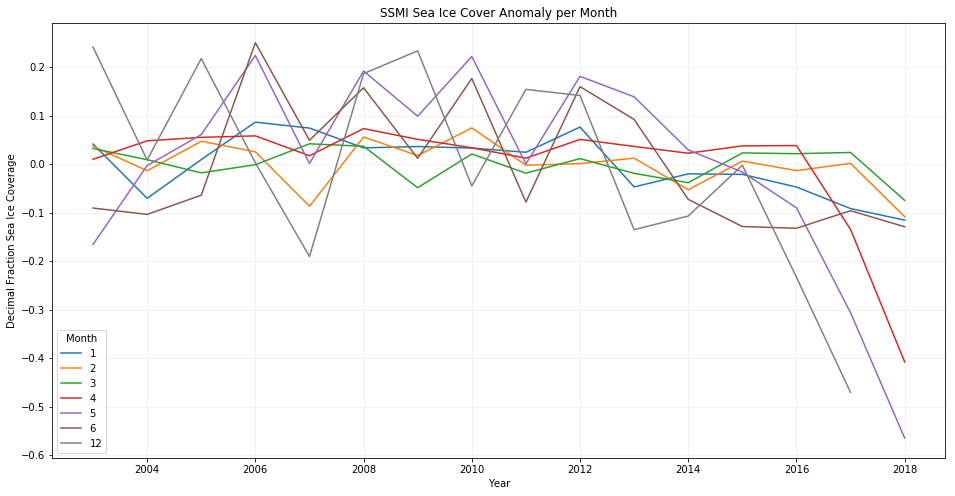

In [48]:
fig, axx = plt.subplots(nrows=1,ncols=1,figsize=(16,8))

si_gb = ssmi_anom.resample(time='1M').mean().groupby('time.month')

handles = {}
for key, group in si_gb:
    if key > 11 or key < 7:
        years = group.time.dt.year.values
        vals = group.values
        h = axx.plot(years,vals)
        handles[key] = h

plt.gca().get_lines()[6].set_color("gray")
plt.grid(alpha=0.2)
plt.legend(handles,loc=3,title='Month')
plt.title('SSMI Sea Ice Cover Anomaly per Month');
axx.set_ylabel('Decimal Fraction Sea Ice Coverage')
axx.set_xlabel('Year');

December, April, and May are the months in which a drastic reduction in ice cover has occured over the past 2 years. January, February, and March display a much smaller recent downward trend. We can further investigate the length of the ice season by plotting each year's timeseries superimposed:

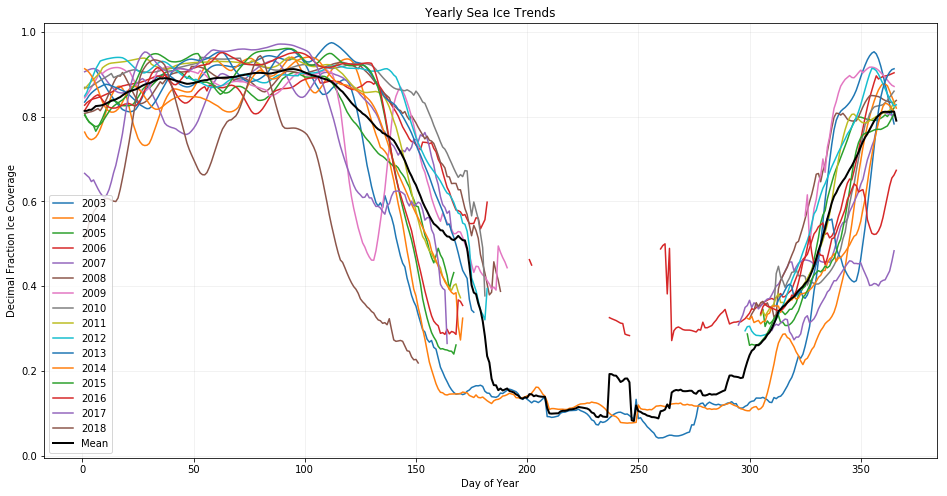

In [49]:
fig, axx = plt.subplots(nrows=1,ncols=1,figsize = (16,8))

all_gb = sst_rey.rolling(time=10, center=True).mean(skipna=True).ice.mean(dim={'lat','lon','zlev'},skipna=True).groupby('time.year')
handles = {}
for key, group in all_gb:
    days = group.time.dt.dayofyear.values
    vals = group.values
    #display(vals)
    h = axx.plot(days,vals)
    handles[key] = h
    

h1 = sst_rey.rolling(time=10, center=True).mean(skipna=True).ice.groupby('time.dayofyear').mean().plot(ax=axx,color='k',linewidth=2)

handles['Mean'] = h1
plt.legend(handles,loc=3)

axx.set_title('Yearly Sea Ice Trends')
axx.set_ylabel('Decimal Fraction Ice Coverage')
axx.set_xlabel('Day of Year');
plt.grid(alpha=0.2)


I'll set a threshold for sea ice cover and see how many days of each winter season exceeded that threshold:

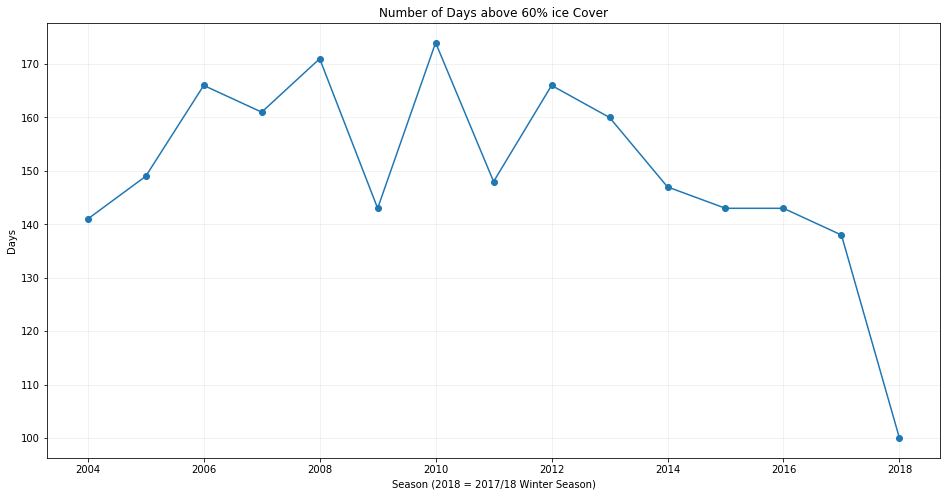

In [50]:
threshold = 0.6

ice_gb = sst_rey.rolling(time=10, center=True).mean(skipna=True).ice.mean(dim={'lat','lon','zlev'},skipna=True).groupby('time.year')
groups = dict(list(ice_gb))

season_counts = {}
for index in np.arange(2004,2019):
    #take the spring season of this year
    spr_count = groups[index].sel(time=slice(f'{index}-01-01',f'{index}-07-01')).where(groups[index]>threshold).count()
    
    #take the fall season of last year
    fall_count = groups[(index-1)].sel(time=slice(f'{index}-10-01',f'{index}-12-31')).where(groups[(index-1)]>threshold).count()

    season_counts[index] = spr_count.values + fall_count.values

seasons = list(season_counts.keys())
counts = list(season_counts.values())
fig, axx = plt.subplots(nrows=1,ncols=1,figsize = (16,8))
axx.plot(seasons, counts,'-o')
axx.set_title('Number of Days above 60% ice Cover')
axx.set_ylabel('Days')
axx.set_xlabel('Season (2018 = 2017/18 Winter Season)');
plt.grid(alpha=0.2)

The length of the sea ice season saw a precipitous drop in 2018. One next step I'll be taking is to establish criteria to quantify the start and end date of the season, and see how each has changed over time to further understand the nature of the season's shrinkage. The hope is to gain some insight into driving factors by differentiating between 'late freeze' and 'early melt' events, which 2017/18 certainly saw both of.

---------------------------------------------------------------------------------

### Investigating Some Correlations

In [51]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims,skipna=True), y - y.mean(dims,skipna=True), dims=dims) / x.count(dims)

def corrrelation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

First, a simple 1-D Correlation between yearly met temperature & yearly sea ice cover:

In [52]:
ssmi_1Y = ssmi_anom.resample(time='1Y').mean()
temp_1Y = met_anom.resample(DATE='Y').mean().HOURLYDRYBULBTEMPC
temp_1Y = temp_1Y.rename({'DATE':'time'})
ssmi_temp_cor = corrrelation(ssmi_1Y,temp_1Y,dims='time')
print(ssmi_temp_cor.values)

-0.8761545611082622


Perhaps unsurprisingly, they are strongly anti-correlated.

But how about a 2-D Correlation between yearly Met temperature and yearly sea ice cover:

In [53]:
reyice_1Y = sst_rey_anom.resample(time='Y').mean().ice.fillna(0)
temp_1Y = met_anom.resample(DATE='Y').mean().HOURLYDRYBULBTEMPC
temp_1Y = temp_1Y.rename({'DATE':'time'})
ice_temp_cor_1Y = corrrelation(reyice_1Y,temp_1Y,dims='time')

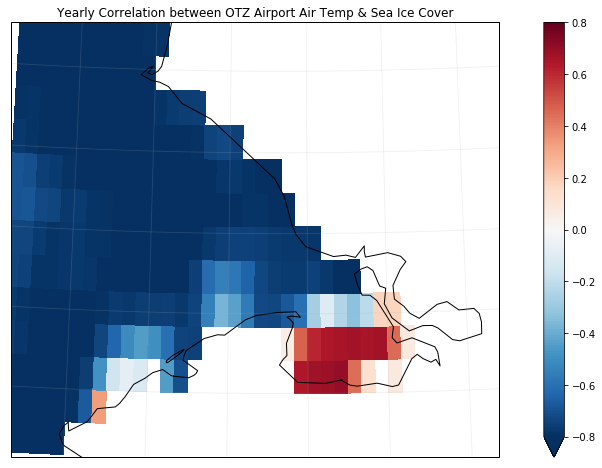

In [54]:
cmin_corr = -0.8
cmax_corr = 0.8

plt.figure(figsize = (16,8))
axx = plt.axes(projection=ccrs.LambertConformal(central_longitude=-164,central_latitude=67))
axx.set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx.gridlines(alpha=0.2)
axx.coastlines(resolution='50m')
ice_temp_cor_1Y.plot(transform=ccrs.PlateCarree(),ax=axx,vmin=cmin_corr,vmax=cmax_corr,cmap='RdBu_r')
axx.set_title('Yearly Correlation between OTZ Airport Air Temp & Sea Ice Cover');

Interestingly, ice cover in the southern half of Kotzebue sound appears positively correlated with air temperature in Kotzebue. 

I'd also like to investigate 2-D correlation between sea ice cover and SST. They are obviously not going to be correlated in a meaningful way on the same day - I'll investigate a lag correlation over the course of 1 year to see where they are most correlated:

In [55]:
ice = sst_rey_anom.ice.fillna(0).mean(dim={'lat','lon','zlev'})
lag_corr = {}
for lag in np.arange(0,366):
    sst = sst_rey_anom.shift(time=-lag).sst.fillna(0).mean(dim={'lat','lon','zlev'})
    corr = corrrelation(ice,sst,dims='time')
    lag_corr[lag] = corr.values.tolist()

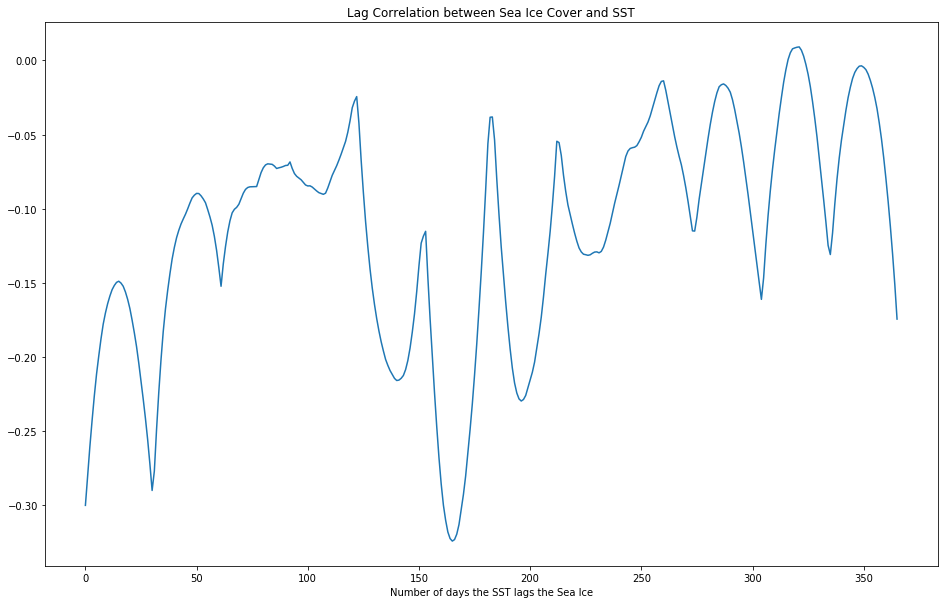

In [56]:
lags = list(lag_corr.keys())
corrs = list(lag_corr.values())
plt.plot(lags,corrs)
plt.title('Lag Correlation between Sea Ice Cover and SST')
plt.xlabel('Number of days the SST lags the Sea Ice');

This is clearly a somewhat imperfect lag correlation as the monthly nature of the anomaly calculation is creeping into the correlation. That being said, the goal was to find an approximate point of maximum anti-correlation.

In [57]:
min(corrs)

-0.3242557324640327

In [58]:
print(list(lag_corr.keys())[list(lag_corr.values()).index(min(corrs))])

165


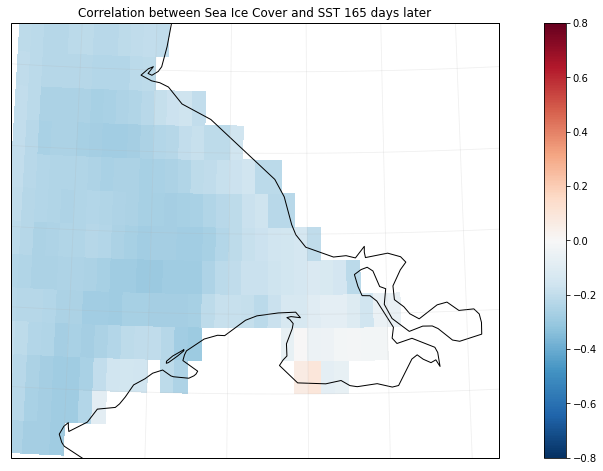

In [59]:
ice = sst_rey_anom.ice.fillna(0)
sst = sst_rey_anom.shift(time=-165).sst.fillna(0)
ice_sst_rey_corr = corrrelation(ice,sst,dims='time')

plt.figure(figsize = (16,8))
axx = plt.axes(projection=ccrs.LambertConformal(central_longitude=-164,central_latitude=67))
axx.set_extent([lon_min+0.3, lon_max, lat_min, lat_max])
axx.gridlines(alpha=0.2)
axx.coastlines(resolution='50m')
ice_sst_rey_corr.plot(transform=ccrs.PlateCarree(),ax=axx,vmin=cmin_corr,vmax=cmax_corr,cmap='RdBu_r')
plt.title('Correlation between Sea Ice Cover and SST 165 days later');

Much remains to be done in order to explain last year's anomaly more completely - I wait with baited breath as well to see how the coming winter unfolds. 